## The investigated question

The sinking of Titanic is probably the most notorious peace time naval disaster in history. As such it is also the show case of the naval code of conduct in such tragic cases. For instance the popular notion, that the captain should leave the ship last likely originates from dramatic portrayals of the Titanic disaster.

Another instance of maritime chivalry dictates, that 'woman and children (are) first' to board the rescue boats. However the 1997 Titanic movie tells a different story. According to the movie, the class and status of passengers took precedence over chivalry, and passengers from lower classes were simply let drown, regardless of their sex and age.

My goal is to investigate whether the data supports either the chivalry or class based rescue protocol

** Does the data provide strong support for some of these claims:**

** Question 1. Had woman a children a higher chance to survive the Titanic  disaster regardless of their class status? **

** Question 2. Had first class passengers a higher chance to survive then woman and children from lower classes?**

## Loading and type casting the data

In [43]:
#reading in csv
import pandas as pd

from IPython.display import display

passengers_df = pd.read_csv("titanic_data.csv")
display(passengers_df.head())

print "size {}".format(len(passengers_df))
print "'Name' type {}".format(passengers_df["Name"].dtype)
print "'Survived' type {}".format(passengers_df["Survived"].dtype)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


size 891
'Name' type object
'Survived' type int64


## Quick Exploration of Data

There are 891 entries in the data set. It appears we can rely on type casting done by pandas. The 'Survived' column is int64. Since  I will count survivors later, I will keep it as an integer and will not cast it to boolean. Others columns which should be strings ('Name', 'Sex') are generic objects, but the entries can be manipulated like strings. For now further type casting does not seem necessary.

In [44]:
def count_values(df,col, normalize = True, dropna=False):
    return df[col].value_counts(normalize = normalize, sort=True, ascending=False, bins=None, dropna = dropna)
 
def print_value_counts(df,col, normalize = True, max_nr = -1):
    print "\n"
    print col
    print "total size: {}".format(len(df[col]))
    print "unique values: {}".format(len(df[col].unique()))
    
    if max_nr == -1:
        max_nr = len(df[col])
    else:
        print "top {} most frequent values:".format(max_nr)
        
    print count_values(df,col,normalize).iloc[:max_nr]

print_value_counts(passengers_df,"Sex")
print_value_counts(passengers_df,"Survived")



Sex
total size: 891
unique values: 2
male      0.647587
female    0.352413
Name: Sex, dtype: float64


Survived
total size: 891
unique values: 2
0    0.616162
1    0.383838
Name: Survived, dtype: float64


According to Wikipedia [Casualties and survivors](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic#Casualties_and_survivors) there were 1316 passengers and 498 survivors (among passengers) which leads to 38% survival rate (since the Kaggle dataset contains only passengers, I consider only passenger information and have excluded crew information from Wikipedia dataset). The provided Kaggle data set contains only 891 data entries. ** Are the survival trend similar both in the Wikipedia and Kaggle dataset?**

**Note 1:** The Wikipedia dataset considers only passenger data and does NOT include crew data

It should be pointed out that any (and in particular passenger) data from the Titanic disaster is quite noisy, due to the historic era and tragic circumstances. According to Wikipedia page referenced earlier, the death toll was estimated between 1,490 and 1,635. This range represents about 11% of people aboard (in total 2224, 1316 passengers + 908  crew). So there is no clear ground truth to compare to.

Of course I do not know whether the same data was used to generate the report from Wikipedia and to create the Kaggle sample. But it seems reasonable to assume that the general trends should be the same in both datasets.

Let us adopt the following assumption, which we will revisit later.

**Assumption 1: The Kaggle data is a representative sample of the (population of) passengers of the Titanic (as described in Wikipedia).**

**Question 3: Does Assumption 1 hold?**

As a quick check the survivor rate is very similar in the both data sets (38% in Kaggle vs 37% in Wikipedia). The proportion of woman is also very similar around 35% in both Kaggle and Wikipedia. 

Note that Wikipedia lists adults and children separately and reports only 31% female passengers. About 8% of passengers are listed as children. Using the [passenger List](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic#Passenger_list) from Wikipedia and assuming that passengers of age 12 and below are considered children (more on that in [Age limit for children](#age) sections). Now I know that there are 53 girls among the children. If I count them as woman, the total percentage of woman in the Wikipedia dataset rises to 35%.

For now Assumption 1 seems to hold. However if this would not be the case, the applicability of conclusions drawn from Kaggle data on the historical Titanic disaster would be questionable.

To investigate **Question 1**, I will need the age limit for a child applied in 1912. Ideally I would like to use the same value as was adopted in the Wikipedia article, so that the results are comparable. Unfortunately Wikipedia does not explicitly state such age limit for a child. I will address this issue in [Data Wrangling](#age) phase.

For my investigation I will need the values for 'Age', 'Pclass', 'Fare' (which I will use to recognize child passengers), 'Sex' and of course 'Survived' for each passenger.

'Age' proves to be problematic since, since about 20% of passengers (177 passengers) don't have an entry for 'Age'.

In [45]:
print_value_counts(passengers_df,"Age", max_nr =5)



Age
total size: 891
unique values: 89
top 5 most frequent values:
NaN      0.198653
 24.0    0.033670
 22.0    0.030303
 18.0    0.029181
 30.0    0.028058
Name: Age, dtype: float64


The remaining relevant fields 'Pclass', 'Sex' and 'Survived' nicely partition the data into two or three (for 'Pclass') partitions.

To be on the safe side I have checked whether 'Name' and  'PassengerId' provide a unique identifier for each data point. They indeed do.

## Data Wrangling Phase

For this investigation Data Wrangling consists of two steps:

1. Remove the 177 Passengers with unspecified age from the dataset
2. Add a new (boolean) field 'Child' dataset

The first step is straightforward:

In [46]:
passengers_df_age = passengers_df.dropna(subset =  ["Age"])
#check whether the clean dataset has the right nr of entries 891-177 = 714
print len(passengers_df_age)

714


I was curious why there are so many NaN values. The [passenger List](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic#Passenger_list) at Wikipedia lists only two passengers of unknown age.

My first idea was, that the majority of unknown age passengers did not survive to report their age. The data shows this is the case for 70% of them.

In [47]:
print_value_counts( passengers_df[passengers_df['Age'].isnull()],"Survived")



Survived
total size: 177
unique values: 2
0    0.706215
1    0.293785
Name: Survived, dtype: float64


**Note 2** The Kaggle dataset contains 177 passengers of unknown age. The Wikipedia Passenger List has only 2.

Does the proportion of woman and survivors change when passengers of unknown age are removed from the dataset?

In [48]:
def print_pretty_percent(df, prefix, field, val):
    print "{0:s} {1:2.2f}%".format(prefix, (count_values(df,field)[val])*100)

print_pretty_percent(passengers_df, "Woman before\t\t",'Sex','female');
print_pretty_percent(passengers_df_age, "Woman after\t\t",'Sex','female');
print "Woman Wikipedia\t\t {0:2.2f}%\n".format(34.57)

print_pretty_percent(passengers_df, "Survived before\t\t",'Survived',1);
print_pretty_percent(passengers_df_age, "Survived after\t\t",'Survived',1);
print "Survived Wikipedia\t {0:2.2f}%\n".format(37.84)

Woman before		 35.24%
Woman after		 36.55%
Woman Wikipedia		 34.57%

Survived before		 38.38%
Survived after		 40.62%
Survived Wikipedia	 37.84%



Both proportions increase only slightly.

<a id='age'></a> **Age limit for children - Wikipedia**

Wikipedia provides two sources with relevant information about age and children passengers. [Casualties and survivors](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic#Casualties_and_survivors) reports summary data for children split by classes. [passenger List](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic#Passenger_list) contains the passengers list for each class and it reports survival, age and gender (indirectly through using the title 'Miss' or 'Master') for each passenger.

We can speculate about the cut-off age used in 'Casualties and survivors' by comparing the reported counts with cumulative counts for different cut-off ages from the 'Passenger List'. Effectively we perform a small Data Acquisition step from a different data source ('Passenger List') to disambiguate the data in an existing data source (finding the exact cut-off age/Operational Definition for 'child' used in 'Casualties and Survivors').

By ordering the survivors in 'Passenger List' by age, we obtain the following counts:


In [49]:
wiki_children = pd.DataFrame({"Wiki": [6,24,79,109],
                              "<=11": [5,22,76,103],
                              "<=12": [5,24,80,109],
                              "<=13": [7,25,83,115],
                              "<=14": [7,27,89,123]},
                              index = ["Class I","Class II", "Class III","Total"])

display(wiki_children.style.set_caption('Cut-off ages comparison'))

#subtract Wiki column from the others
diff_df = wiki_children.sub(wiki_children["Wiki"],axis = 0)
#remove it from the view + apply abs 
diff_df = diff_df.iloc[:,:4].applymap(abs)
# highlight min in each row
diff_df.style.highlight_min(axis=1).set_caption('Cut-off ages diff')


The age 12 and below seems to be the most likely cut-off age, although the difference to other candidate ages is not large.

In addition I have attempted to validate the selected age, by checking a strong trend apparent in 'Casualties and survivors': all but one child from Class I and II survived the disaster. Can I observe this trend in passengers of age 12 and below and NOT in passengers of age 13 and below?

In [50]:
def format_percentage(p):
    return "{0:2.2f}%".format(p*100)

def analyze_children_survival (df,age):
    grouped = df[df["Age"]<=age][["Pclass","Survived"]].groupby(["Pclass"])
    
    res = pd.concat([grouped.sum(),grouped.count(),grouped.mean()],axis = 1)
    res.columns = ["Survived","Total","Percentage"]
    res["Percentage"] = res["Percentage"].apply(format_percentage)
   
    return res.style.set_caption("Cut-off age <={}".format(age))

for age in [11, 12, 15, 16]:
    display(analyze_children_survival(passengers_df_age, age))


Unfortunatelly the mentioned trend can be observed for ages up to 16 (exclusive). So observing this trend does not provide additional support for 12 years as cut-off age.

**Age limit for children - Kaggle**

Wikipedia also mentions ticket prices. For [Class I](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic#First_class) and [Class II](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic#Second_class)  only a price range a nd average price are reported. But a [Class III](https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic#Third_class) ticket cost £3 for a child and £7 for an adult.

The 'Fares' in the Kaggle data set look like this.

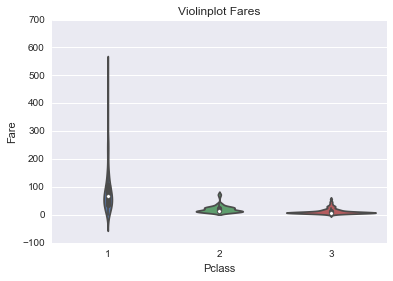

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
ax.set_title('Violinplot Fares')

sns.violinplot(x="Pclass", y="Fare", data=passengers_df_age, inner = "box", ax = ax)

This plot implies that there are some Class I passengers with negative Fare! This is not the case and probably an artifact of the used kernel. This can be seen from the boxplot.

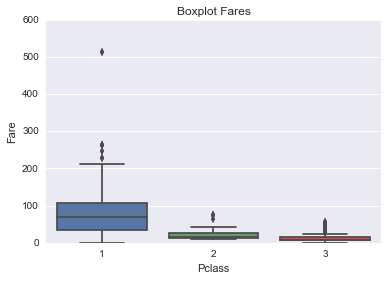

In [52]:
ax =plt.axes()
ax.set_title('Boxplot Fares')
sns.boxplot(x="Pclass", y="Fare",data=passengers_df_age)

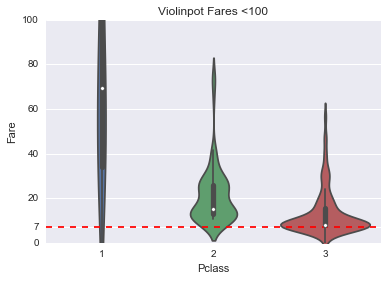

In [53]:
ax =plt.axes()
ax.set_title('Violinpot Fares <100')
ax.set_ylim([0,100])

ax.axhline(y=7.0, color='r', ls='--',label='p=0.05')
plt.yticks(list(plt.yticks()[0]) +[7.0])

sns.violinplot(x="Pclass", y="Fare",data=passengers_df_age,inner = "box", ax = ax)

The ticket price often included the cost of a train ticket to the port, so the final price is usually slightly higher the £7. The violinplot shows that many passengers indeed traveled on ticket around that prize. I can use this information to estimate the cut-off age using the 'Fare' column. I would expect to see a sharp increase of mean and minimum ticket price above the cut-off age.

In [54]:
def analyze_children_fare (df, max_age, pclass):
    #print "Child of {} years".format(age)
    
    grouped = df[df["Pclass"]== 3][["Age","Fare"]]
    grouped = grouped[grouped["Age"]<=max_age].groupby(["Age"])
    res = pd.concat([grouped.min(),grouped.mean(),grouped.max(),grouped.count()],axis = 1)
    res.columns = ["Min","Mean","Max","Count"]
    return res

def highligh_cheap_fare(val):
    if (7.0 <= val and val <=9.0):
        color = 'red' 
    else:
        color = 'black'
    return 'color: %s' % color

child_fare_df = analyze_children_fare(passengers_df_age,16,3)

#highlight
display(child_fare_df.style.applymap(highligh_cheap_fare, subset = ["Min","Mean"])\
        .set_caption("Fare by Age"))

Indeed there are some passengers travelling on cheap adult tickets (highlighted in red). Surprisingly tickets for young children cost much more then the expected £3 and £7. It turns out that these passengers travel on group/family ticket, or for free if they are really small. The following view demonstrates the existence of such group tickets. 

In [55]:
#group tickets
display(passengers_df_age[passengers_df_age["Pclass"]== 3].groupby(["Ticket","Age","Fare","SibSp","Parch"]).size().iloc[:50])

Ticket   Age    Fare     SibSp  Parch
14973    22.00  8.0500   0      0        1
1601     26.00  56.4958  0      0        1
         28.00  56.4958  0      0        1
         32.00  56.4958  0      0        2
21440    51.00  8.0500   0      0        1
2223     18.00  8.3000   0      0        1
2620     22.00  7.2250   0      0        1
2623     40.00  7.2250   0      0        1
2625     0.42   8.5167   0      1        1
2627     17.00  14.4583  0      0        1
2628     45.50  7.2250   0      0        1
2648     20.00  4.0125   0      0        1
2650     29.00  15.2458  0      2        1
2651     12.00  11.2417  1      0        1
         14.00  11.2417  1      0        1
2653     1.00   15.7417  0      2        1
         20.00  15.7417  1      1        1
2659     15.00  14.4542  1      0        1
         27.00  14.4542  1      0        1
2663     20.00  7.2292   0      0        1
2665     14.50  14.4542  1      0        1
2666     0.75   19.2583  2      1        2
         5.00   

Let me consider only single tickets now.

In [56]:
#returns list of tickets associated with only one passenger
def filter_single_tickets(df):
    #Series with single ticket names
    grouped = df.groupby(["Ticket"]).size()
    single_t = grouped[grouped == 1].index.tolist()

    return df[df["Ticket"].isin(single_t)]

single_ticket_only_df = filter_single_tickets(passengers_df_age)
selected_age_df = single_ticket_only_df[(single_ticket_only_df["Age"] >=0.0) & (single_ticket_only_df["Age"] <=15)]
display(selected_age_df[["Ticket","Age","Pclass","Fare","SibSp","Parch"]].sort_values("Age").style\
        .applymap(highligh_cheap_fare, subset = ["Fare"])
        .set_caption("Single tickets by Age - Cheap Fare"))

It seems that a 13 year old can already travel on her own (ticket "2687"). So 12 years indeed seems to be the right cut-off age.

There are some very small children (tickets "3101298", "315153", "349256") who couldn't possibly travel on their own. They likely travelled with their parents (family ticket 'Fare', 'age' <= 4, 'pchar' >1 and as children from Class III they likely would not have a nanny). But there is no record of their parents or other passengers travelling on the same ticket. Therefore I suspect that the Kaggle dataset is incomplete and some passenger records are missing.

**Note 3: The Kaggle dataset is incomplete. In particular data about families is incomplete and some family members are clearly missing.**

In [57]:
#check whether there indeed no passengers travelling on the same ticket as the small children
passengers_df_age[passengers_df_age["Ticket"].isin(["3101298","315153","349256"])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
184,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S
479,480,1,3,"Hirvonen, Miss. Hildur E",female,2.0,0,1,3101298,12.2875,NaN,S
691,692,1,3,"Karun, Miss. Manca",female,4.0,0,1,349256,13.4167,NaN,C


**Age limit for children - Conclusion**

**A passenger is considered a child if he or she is 12 or younger**

I will add a new column 'Pcat' (Passenger Category) which takes value 'child', 'female', 'male' depending on the sex and age of the passenger.

In [58]:
col_sex = passengers_df_age.loc[:,'Sex'].copy()

#this raises SettingWithCopyWarning
passengers_df_age.loc[:,'Pcat'] = col_sex 

#I get SettingWithCopyWarning here. Since I copy the collumn everything should be fine.
#But I kept the warning here, to be sure.

In [59]:
def set_child(row):
    if row["Age"] <= 12:
        row["Pcat"]="child"
    return row

passengers_df_age = passengers_df_age.apply(set_child,axis =1)

In [60]:
#quick check whether it worked
#passengers_df_age.head(30)[["Sex","Age","Pcat"]]

## Exploration Phase

I will use group by to produce a summary data frame reporting the survival rates for passengers from various classes and rescue categories.

In [61]:
def get_summary(df,Pcat):
    res = df[df["Pcat"] == Pcat]
    return pd.DataFrame({Pcat : res.groupby( ["Pclass","Survived"] ).size()}).reset_index()

summary_df_kaggle = get_summary(passengers_df_age,"child")

#insert the missing row for children from class II who did not survive
#if I would not add this, subsequent merges would introduce NaN and cast columns to doubles

#copy the closest row
missing_row = summary_df_kaggle.loc[2].copy()
#change it
missing_row["Survived"] = 0
missing_row["child"] = 0

#add it on position 2
summary_df_kaggle =summary_df_kaggle.loc[0:1].append(missing_row).append(summary_df_kaggle.loc[2:])
#reset index
summary_df_kaggle.index = range(6)

#test whether it worked
#display(summary_df_kaggle)

#merge the diffent rescue classes
summary_df_kaggle = summary_df_kaggle.merge(get_summary(passengers_df_age,"female"),on = ["Pclass","Survived"])
summary_df_kaggle = summary_df_kaggle.merge(get_summary(passengers_df_age,"male"),on = ["Pclass","Survived"])

display(summary_df_kaggle.style.set_caption("Survival by Class and Pcat"))

Now I will visualize the survival counts separatelly for each passenger  category ('child','female' and 'male'). Each bar represents either survivors (suffix '-S') or casualties (suffix '-D') for each passenger class ('I','II' and 'III'). Survivors are represented by red, green, blue colour and casualties by darker shades of those colours.

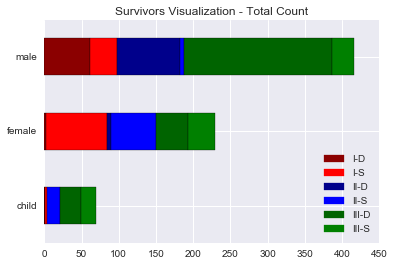

In [62]:
import matplotlib.patches as mpatches

def draw_bar_chart(df, title):
    c_list = ["darkred","red","darkblue","blue","darkgreen","green"]
    l_list = ["I-D","I-S","II-D","II-S","III-D","III-S"]

    #Normaly plot.bar takes each row for one bar. However I would like to aggregate by the 
    #column. df.T provides the transposed data frame which is what I want.
    df[["child","female","male"]].T.plot.barh(color = c_list,\
              label = l_list, legend =True, stacked=True)
    
    ax = plt.axes()
    ax.set_title(title)
    
    handles =[]
    
    for i in range(len(c_list)):
        handles.append(mpatches.Patch(color=c_list[i], label=l_list[i]))

    plt.legend(handles=handles, loc = 4)
    
draw_bar_chart(summary_df_kaggle, 'Survivors Visualization - Total Count')

The number of passengers varies a lot across passenger categories. This makes direct comparison between categories difficult. Therefore I will visualize percentage separately for each category.

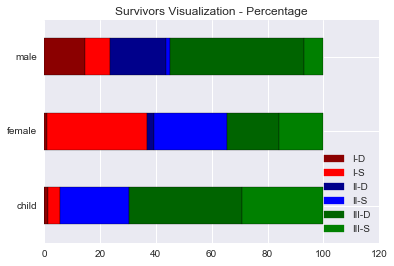

In [63]:
draw_bar_chart(summary_df_kaggle[["child","female","male"]]/summary_df_kaggle[["child","female","male"]].sum()*100, 'Survivors Visualization - Percentage')

Indeed one can see that the death toll is the heaviest among male passengers (confirming 'woman and children first'). The plots also show that for each category the death toll increases with class (confirming 'class precedence').

Lastly I looked into survival chances under different circumstances. E.g. what is a chance of survival of a female passenger travelling II Class? 90.91%.

In [64]:
def count_to_percent(col):
    res = pd.Series(0.0, index = col.index)
    
    size = len(col)/2
    
    for i in range(size):
        per = col[2*i]
        sur = col[(2*i)+1]
        tot = float(sur+per)
        
        #format to percent
        res[2*i] = float("{0:.2f}".format(per/tot*100))
        res[(2*i)+1] = float("{0:.2f}".format(sur/tot*100))
    
    return res

summary_df_kaggle_per =summary_df_kaggle[["child","female","male"]].apply(count_to_percent)
col_copy = summary_df_kaggle["Pclass"].copy()
summary_df_kaggle_per.loc[:,"Pclass"] = col_copy


#add background gradient
cm = sns.light_palette("green", as_cmap=True)

summary_df_kaggle_per[ summary_df_kaggle["Survived"] == 1][["Pclass","child","female","male"]]\
.style.background_gradient(subset = ["child","female","male"], cmap=cm)

This table clearly shows that survival rate are much higher for woman and children from Class I and II. While only one child from Class I has perished, there were only 5 children travelling Class I in total. This results in relatively low 75%.

Among the males, survival rate is much higher in Class I.

** Comparing with Wikipedia**

In order to compare the Wikipedia and Kaggle dataset I have to normalize them first, since they have different size. I will do this by dividing the dataframes by the total number of passengers in each one. 

In [65]:
summary_df_wiki = summary_df_kaggle.copy()

#insert data from wikipedia
index = summary_df_kaggle.index

summary_df_wiki["child"] = pd.Series([1,5,0,24,52,27], index)
summary_df_wiki["female"] = pd.Series([4,140,13,80,89,76], index)
summary_df_wiki["male"] = pd.Series([118,57,154,14,387,75], index)

def format_percent(cell):
    return float("{0:.2f}".format(cell*100))

def normalize(df):
    res = df.copy()
    total = res[["child","female","male"]].sum().sum()
    
    res[["child","female","male"]] = (res[["child","female","male"]]/total)
    res[["child","female","male"]] = res[["child","female","male"]].applymap(format_percent) 
    
    return res

summary_df_wiki_norm = normalize(summary_df_wiki)
summary_df_kaggle_norm = normalize(summary_df_kaggle)

Now I will subtract the two normalized data frames and visualize the differences between the two datasets.

In [66]:
summary_df_diff = summary_df_kaggle_norm - summary_df_wiki_norm 
summary_df_diff[["Pclass","Survived"]] = summary_df_wiki[["Pclass","Survived"]]

summary_df_diff\
.style.background_gradient(subset = ["child","female","male"], cmap=cm)

The table shows that two datasets exhibit roughly the same trends. In addition these trends manifest themselves stronger in the Kaggle dataset.

For children the survival rate has increased considerably in Class II and Class III, while it stayed the same for Class I. Similarly the survival rate for woman in Class I and II and man in Class I have also increased. These gains were compensated by drop of survival rate for both woman and man in Class III. 

## Conclusion 

Based on the described analysis of the Kaggle dataset, I can now answer the stated questions.

** Question 1. Had woman a children a higher chance to survive the Titanic  disaster regardless of their class status? **

Yes. The survival rate was much higher for woman and children then for man in the same class. Children from Class has the lowest survival among woman an children 41.67%. But it was still slightly then highest survival rate for men (in the Class I) 37.76%.

** Question 2. Had first class passengers a higher chance to survive then woman and children from lower classes?**

Yes, kind of. It is true for woman and children. The survival rate was the worst for the III Class among woman and children.

As for men, the absolutely worst survival rate was for man in Class II - only 6.67%, followed by man in Class III - 12.72%. The highest survival rate for man was in Class I - 37.76%. This was slightly less then the 41.76% survival rate for Class III children, which is the lowest one among woman and children.

**Question 3: Is the Kaggle data is a representative sample of the (population of) passengers of the Titanic (as described in Wikipedia)?**

The trends in survival observed in the Kaggle dataset also occur in the Wikipedia dataset. The trends in Kaggle dataset even appear to be considerably stronger.

It should be noted that I did not conduct a rigorous statical test. Since the number of classes is small, the distribution is binary and the trends are clear, my investigation seemed sufficient. 

I would expect that a rigourous statistical test would confirm my finding.